<a href="https://colab.research.google.com/github/gwcat0506/OPEN_SW_COMPETITION/blob/main/SW%EB%8C%80%ED%9A%8C_%ED%96%A5%EC%88%98%EC%98%88%EC%B8%A1GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. rdkit 설치**

분자를 molecular graph 형태로 만들어 주고 OO한 rdkit을 설치합니다. 

In [ ]:
%%bash
add-apt-repository ppa:ubuntu-toolchain-r/test
apt-get update --fix-missing
apt-get dist-upgrade
wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
chmod +x Miniconda3-latest-Linux-x86_64.sh
./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
conda config --set always_yes yes --set changeps1 no
conda install -q -y -c conda-forge python=3.7
conda install -q -y -c conda-forge rdkit 

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

try:
  from rdkit import Chem
  from rdkit.Chem.Draw import IPythonConsole
except ImportError:
  print('Stopping RUNTIME. Colaboratory will restart automatically. Please run again.')
  exit()

**2. 전처리**

ZINC.smiles 파일에 text로 표현되어 있는 분자들을 molecular graph 형태로 바꿔줍시다. 이때 node feature matrix는 아래 그림과 같이 각 원자의 symbol, degree 등 화학적 특성을 one-hot vector로 나타낸 형태입니다.

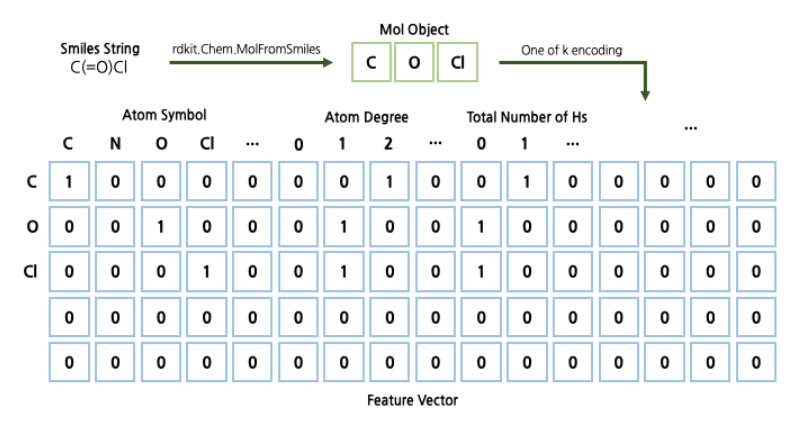



read_ZINC_smiles 함수는 smiles 파일 내의 분자 텍스트의 list와 각 분자들의 실제 logP value list를 return합니다. convert_to_graph 함수는 분자 텍스트의 list를 받아 각 분자들의 node feature matrix list와 adjacency matrix list를 return 합니다.

In [ ]:
import argparse
import sys
import time
import copy

import numpy as np

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP

from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

#from utils import read_ZINC_smiles, smiles_to_onehot, partition, OneHotLogPDataSet
import tqdm
# import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = True
args.batch_size = 100
args.lr = 0.001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 100
args.n_block = 3
args.n_layer = 1
args.n_atom = 50
args.in_dim = 58
args.hidden_dim = 256
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 256
args.out_dim = 1
args.bn = True
args.sc = 'gsc'
args.atn = True
args.num_head = 16
args.dropout = 0
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
np.random.seed(args.seed)
torch.manual_seed(args.seed)

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')



# csv 파일 업로드 하기!

 각자 아래 코드 돌리고 csv 파일 선택해서 upload 해주세요

메인코드에 csv 파일명이랑 upload 한 파일명이 일치한지 확인 꼭 하기 ♥

In [ ]:
#csv 파일 업로드하기

from google.colab import files

myfile = files.upload()

In [ ]:
import io
import pandas as pd

In [ ]:
# csv 파일 연동 됐는지 확인하기 -> 확인완료

# f = open('향료 데이터_csv1.csv', 'r', encoding="euc-kr", errors='ignore')

# contents = f.readlines()
# print(contents)

# 메인코드


제가 지금 현재까지 은호님이랑 재욱님 코드를 몰라서
일단 아무코드(?)나 적어놨으니
이 부분은 수정하시면 됩니다.

In [ ]:

# 수정필요



def read_ZINC_smiles(num_mol):
    f = open('향료 데이터_csv1.csv', 'r', encoding="euc-kr", errors='ignore')

    contents = f.readlines()

    smi_list = []
    logP_list = []

    for i in tqdm.tqdm(range(num_mol), desc='Reading Data'):
        smi = contents[i].strip()
        m = Chem.MolFromSmiles(smi)
        smi_list.append(smi)
        if m != None:
            logP_list.append(MolLogP(m))

    logP_list = np.asarray(logP_list).astype(float)

    return smi_list, logP_list

def smiles_to_onehot(smi_list):
    def smiles_to_vector(smiles, vocab, max_length):
        while len(smiles) < max_length:
            smiles += " "
        vector = [vocab.index(str(x)) for x in smiles]
        one_hot = np.zeros((len(vocab), max_length), dtype=int)
        for i, elm in enumerate(vector):
            one_hot[elm][i] = 1
        return one_hot

    vocab = np.load('./vocab.npy')

    a = np.array(
        [['E'], ['.'], ['N'], ['Z'], ['r'], ['J'], ['W'], ['9'], ['G'], ['5'], ['n'], ['T'], ['e'], ['/'], ['#'], ['3'],
         ['v'], ['I'], ['8'], ['('], ['B'], ['='], ['A'], ['S'], [' '], [']'], ['U'], ['['], ['7'], ['L'], ['-'], ['C'],
         ['F'], ['+'], ['2'], ['\\'], ['Q'], ['@'], ['P'], ['M'], ['a'], ['l'], ['Y'], ['D'], ['O'], ['V'], [')'],
         ['g'], ['6'], ['4'], ['1'], ['H'], ['X']])

    vocab = np.union1d(vocab, a)

    smi_total = []

    for i, smi in tqdm.tqdm(enumerate(smi_list), desc='Converting to One Hot'):
        smi_onehot = smiles_to_vector(smi, list(vocab), 282)
        smi_total.append(smi_onehot)
    return np.asarray(smi_total)

def convert_to_graph(smiles_list):
    adj = []
    adj_norm = []
    features = []
    maxNumAtoms = 50
    for i in tqdm.tqdm(smiles_list, desc='Converting to Graph'):
        # Mol
        iMol = Chem.MolFromSmiles(i.strip())
        #Adj
        if iMol !=  None:
            iAdjTmp = Chem.rdmolops.GetAdjacencyMatrix(iMol)

            # Feature
            if( iAdjTmp.shape[0] <= maxNumAtoms):
                # Feature-preprocessing
                iFeature = np.zeros((maxNumAtoms, 58))
                iFeatureTmp = []

                for atom in iMol.GetAtoms():
                    iFeatureTmp.append( atom_feature(atom) ) ### atom features only
                iFeature[0:len(iFeatureTmp), 0:58] = iFeatureTmp ### 0 padding for feature-set
                features.append(iFeature)

                # Adj-preprocessing
                iAdj = np.zeros((maxNumAtoms, maxNumAtoms))
                iAdj[0:len(iFeatureTmp), 0:len(iFeatureTmp)] = iAdjTmp + np.eye(len(iFeatureTmp))
                adj.append(np.asarray(iAdj))

    features = np.asarray(features)

    return features, adj

def atom_feature(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                      ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
                                       'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B',
                                       'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                                       'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) +
                    [atom.GetIsAromatic()])    # (40, 6, 5, 6, 1)

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

list_smi, list_logP = read_ZINC_smiles(4040)
list_feature, list_adj = convert_to_graph(list_smi)

class GCNDataset(Dataset):
    def __init__(self, list_feature, list_adj, list_logP):
        self.list_feature = list_feature
        self.list_adj = list_adj
        self.list_logP = list_logP

    def __len__(self):
        return len(self.list_feature)

    def __getitem__(self, index):
        return self.list_feature[index], self.list_adj[index], self.list_logP[index]


def partition(list_feature, list_adj, list_logP, args):
    num_total = list_feature.shape[0]
    num_train = int(num_total * (1 - args.test_size - args.val_size))
    num_val = int(num_total * args.val_size)
    num_test = int(num_total * args.test_size)

    feature_train = list_feature[:num_train]
    adj_train = list_adj[:num_train]
    logP_train = list_logP[:num_train]
    feature_val = list_feature[num_train:num_train + num_val]
    adj_val = list_adj[num_train:num_train + num_val]
    logP_val = list_logP[num_train:num_train + num_val]
    feature_test = list_feature[num_total - num_test:]
    adj_test = list_adj[num_total - num_test:]
    logP_test = list_logP[num_total - num_test:]

    train_set = GCNDataset(feature_train, adj_train, logP_train)
    val_set = GCNDataset(feature_val, adj_val, logP_val)
    test_set = GCNDataset(feature_test, adj_test, logP_test)

    partition = {
        'train': train_set,
        'val': val_set,
        'test': test_set
    }

    return partition

list_smi, list_logP = read_ZINC_smiles(4040)
list_feature, list_adj = convert_to_graph(list_smi)
dict_partition = partition(list_feature, list_adj, list_logP, args)
dict_result = dict()
list_lr = [0.01, 0.001, 0.0001, 0.00001]
list_n_block = [1, 2, 3]
n_iter = len(list_n_block)*len(list_lr)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm.tqdm(total=n_iter, file=sys.stdout, position=0)
#
class GCNLayer(nn.Module):

    def __init__(self, in_dim, out_dim, n_atom, act=None, bn=False, atn=False, num_head=1, dropout=0):
        super(GCNLayer, self).__init__()

        self.use_bn = bn
        self.use_atn = atn
        self.linear = nn.Linear(in_dim, out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.bn = nn.BatchNorm1d(n_atom)
        self.attention = Attention(out_dim, out_dim, num_head)
        self.activation = act
        self.dropout_rate = dropout
        self.dropout = nn.Dropout2d(self.dropout_rate)

    def forward(self, x, adj):
        out = self.linear(x)
        if self.use_atn:
            out = self.attention(out, adj)
        else:
            out = torch.matmul(adj, out)
        if self.use_bn:
            out = self.bn(out)
        if self.activation != None:
            out = self.activation(out)
        if self.dropout_rate > 0:
            out = self.dropout(out)
        return out, adj


class SkipConnection(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(SkipConnection, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.linear = nn.Linear(in_dim, out_dim, bias=False)

    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        out = in_x + out_x
        return out


class GatedSkipConnection(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(GatedSkipConnection, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        self.linear_coef_in = nn.Linear(out_dim, out_dim)
        self.linear_coef_out = nn.Linear(out_dim, out_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        z = self.gate_coefficient(in_x, out_x)
        out = torch.mul(z, out_x) + torch.mul(1.0 - z, in_x)
        return out

    def gate_coefficient(self, in_x, out_x):
        x1 = self.linear_coef_in(in_x)
        x2 = self.linear_coef_out(out_x)
        return self.sigmoid(x1 + x2)


class Attention(nn.Module):

    def __init__(self, in_dim, output_dim, num_head):
        super(Attention, self).__init__()

        self.num_head = num_head
        self.atn_dim = output_dim // num_head

        self.linears = nn.ModuleList()
        self.corelations = nn.ParameterList()
        for i in range(self.num_head):
            self.linears.append(nn.Linear(in_dim, self.atn_dim))
            corelation = torch.FloatTensor(self.atn_dim, self.atn_dim)
            nn.init.xavier_uniform_(corelation)
            self.corelations.append(nn.Parameter(corelation))

        self.tanh = nn.Tanh()

    def forward(self, x, adj):
        heads = list()
        for i in range(self.num_head):
            x_transformed = self.linears[i](x)
            alpha = self.attention_matrix(x_transformed, self.corelations[i], adj)
            x_head = torch.matmul(alpha, x_transformed)
            heads.append(x_head)
        output = torch.cat(heads, dim=2)
        return output

    def attention_matrix(self, x_transformed, corelation, adj):
        x = torch.einsum('akj,ij->aki', (x_transformed, corelation))
        alpha = torch.matmul(x, torch.transpose(x_transformed, 1, 2))
        alpha = torch.mul(alpha, adj)
        alpha = self.tanh(alpha)
        return alpha


class GCNBlock(nn.Module):

    def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_atom, bn=True, atn=True, num_head=1, sc='gsc',
                 dropout=0):
        super(GCNBlock, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(n_layer):
            self.layers.append(GCNLayer(in_dim if i == 0 else hidden_dim,
                                        out_dim if i == n_layer - 1 else hidden_dim,
                                        n_atom,
                                        nn.ReLU() if i != n_layer - 1 else None,
                                        bn,
                                        atn,
                                        num_head,
                                        dropout))
        self.relu = nn.ReLU()
        if sc == 'gsc':
            self.sc = GatedSkipConnection(in_dim, out_dim)
        elif sc == 'sc':
            self.sc = SkipConnection(in_dim, out_dim)
        elif sc == 'no':
            self.sc = None
        else:
            assert False, "Wrong sc type."

    def forward(self, x, adj):
        residual = x
        for i, layer in enumerate(self.layers):
            out, adj = layer((x if i == 0 else out), adj)
        if self.sc != None:
            out = self.sc(residual, out)
        out = self.relu(out)
        return out, adj


class ReadOut(nn.Module):

    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, 1)
        if self.activation != None:
            out = self.activation(out)
        return out


class Predictor(nn.Module):

    def __init__(self, in_dim, out_dim, act=None):
        super(Predictor, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
        return out


class GCNNet(nn.Module):

    def __init__(self, args):
        super(GCNNet, self).__init__()

        self.blocks = nn.ModuleList()
        for i in range(args.n_block):
            self.blocks.append(GCNBlock(args.n_layer,
                                        args.in_dim if i == 0 else args.hidden_dim,
                                        args.hidden_dim,
                                        args.hidden_dim,
                                        args.n_atom,
                                        args.bn,
                                        args.atn,
                                        args.num_head,
                                        args.sc,
                                        args.dropout))
        self.readout = ReadOut(args.hidden_dim,
                               args.pred_dim1,
                               act=nn.ReLU())
        self.pred1 = Predictor(args.pred_dim1,
                               args.pred_dim2,
                               act=nn.ReLU())
        self.pred2 = Predictor(args.pred_dim2,
                               args.pred_dim3,
                               act=nn.Tanh())
        self.pred3 = Predictor(args.pred_dim3,
                               args.out_dim)

    def forward(self, x, adj):
        for i, block in enumerate(self.blocks):
            out, adj = block((x if i == 0 else out), adj)
        out = self.readout(out)
        out = self.pred1(out)
        out = self.pred2(out)
        out = self.pred3(out)
        return out


def train(model, device, optimizer, criterion, data_train, bar, args):
    epoch_train_loss = 0
    for i, batch in enumerate(data_train):
        list_feature = batch[0].clone().detach().to(device).float()
        list_adj = batch[1].clone().detach().to(device).float()
        list_logP = batch[2].clone().detach().to(device).float()
        list_logP = list_logP.view(-1, 1)

        model.train()
        optimizer.zero_grad()
        list_pred_logP = model(list_feature, list_adj)
        list_pred_logP.require_grad = False
        train_loss = criterion(list_pred_logP, list_logP)
        epoch_train_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()

        bar.update(len(list_feature))

    epoch_train_loss /= len(data_train)

    return model, epoch_train_loss


def validate(model, device, criterion, data_val, bar, args):
    epoch_val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_val):
            list_feature = batch[0].clone().detach().to(device).float()
            list_adj = batch[1].clone().detach().to(device).float()
            list_logP = batch[2].clone().detach().to(device).float()
            list_logP = list_logP.view(-1, 1)

            model.eval()
            list_pred_logP = model(list_feature, list_adj)
            list_pred_logP.require_grad = False
            val_loss = criterion(list_pred_logP, list_logP)
            epoch_val_loss += val_loss.item()

            bar.update(len(list_feature))

    epoch_val_loss /= len(data_val)

    return model, epoch_val_loss


def test(model, device, data_test, args):
    model.eval()
    with torch.no_grad():
        logP_total = list()
        pred_logP_total = list()
        for i, batch in enumerate(data_test):
            list_feature = batch[0].clone().detach().to(device).float()
            list_adj = batch[1].clone().detach().to(device).float()
            list_logP = batch[2].clone().detach().to(device).float()
            logP_total += list_logP.tolist()
            list_logP = list_logP.view(-1, 1)

            list_pred_logP = model(list_feature, list_adj)
            pred_logP_total += list_pred_logP.view(-1).tolist()

        mae = mean_absolute_error(logP_total, pred_logP_total)
        std = np.std(np.array(logP_total) - np.array(pred_logP_total))

    return mae, std, logP_total, pred_logP_total


def experiment(dict_partition, device, bar, args):
    time_start = time.time()

    model = GCNNet(args)
    model.to(device)

    if args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),
                                  lr=args.lr,
                                  weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(),
                              lr=args.lr,
                              weight_decay=args.l2_coef)
    else:
        assert False, 'Undefined Optimizer Type'

    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step_size,
                                          gamma=args.gamma)

    list_train_loss = list()
    list_val_loss = list()

    data_train = DataLoader(dict_partition['train'],
                            batch_size=args.batch_size,
                            shuffle=args.shuffle)

    data_val = DataLoader(dict_partition['val'],
                          batch_size=args.batch_size,
                          shuffle=args.shuffle)

    for epoch in range(args.epoch):
        model, train_loss = train(model, device, optimizer, criterion, data_train, bar, args)
        scheduler.step()
        list_train_loss.append(train_loss)

        model, val_loss = validate(model, device, criterion, data_val, bar, args)
        list_val_loss.append(val_loss)

    data_test = DataLoader(dict_partition['test'],
                           batch_size=args.batch_size,
                           shuffle=args.shuffle)

    mae, std, logP_total, pred_logP_total = test(model, device, data_test, args)

    time_end = time.time()
    time_required = time_end - time_start

    args.list_train_loss = list_train_loss
    args.list_val_loss = list_val_loss
    args.logP_total = logP_total
    args.pred_logP_total = pred_logP_total
    args.mae = mae
    args.std = std
    args.time_required = time_required

    return args
# GCNNet(args)



dict_result = dict()
n_iter = args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm.tqdm(total=n_iter, file=sys.stdout, position=0)

args.exp_name = "result 190000"
result = vars(experiment(dict_partition, device, bar, args))
dict_result[args.exp_name] = copy.deepcopy(result)

torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('result 190000.JSON', orient='table')
df_result = pd.read_json('result 190000.JSON', orient='table')

print("MAE: " + str(df_result['mae'][0]))
print("Std: " + str(df_result['std'][0]))

# fig, ax = plt.subplots(1, 2)
# fig.set_size_inches(10, 5)
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# ax[0].plot(df_result['list_train_loss'][0], label='Train Loss')
# ax[0].plot(df_result['list_val_loss'][0], label='Validation Loss')
# ax[0].set_ylim([0, 0.1])
# ax[0].legend()
# ax[1].scatter(df_result['logP_total'][0], df_result['pred_logP_total'][0], alpha=0.3, s=2)
# ax[1].plot(df_result['logP_total'][0], df_result['logP_total'][0], color='black', alpha=0.4)